<a href="https://colab.research.google.com/github/Amelrich/Capstone-Fall-2020/blob/vy-preprocessing/PIP_Embedding_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

In [ ]:
pip install python-fastpip

In [ ]:
!pip install yellowbrick

In [ ]:
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

In [ ]:
try:
  from tslearn.clustering import TimeSeriesKMeans
except:
  !pip -q install tslearn
  from tslearn.clustering import TimeSeriesKMeans

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import numpy.random as rd
import pandas as pd
import numpy as np
import seaborn as sns
from fastpip import pip

import matplotlib.pyplot as plt
import os
%matplotlib inline

from yellowbrick.cluster import KElbowVisualizer
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import asarray
from numpy import save
from itertools import product
from collections import defaultdict

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#os.chdir('/content/drive/My Drive/Capstone - JPM')
#!git clone -l -s https://github.com/Amelrich/Capstone-Fall-2020.git capstone_git_repo_update

In [ ]:
os.chdir('/content/drive/My Drive/Capstone - JPM/capstone_git_repo_update/utilities')

from TS_utils import TS_generator
from TS_utils import MedianScaler, DCT_lowpass_filter
from TS_utils import KMedians

In [ ]:
try:
  from google.colab import files
  !wget -q https://github.com/Amelrich/Capstone-Fall-2020/archive/master.zip
  !unzip -q master.zip
  !mv Capstone-Fall-2020-master/data/ data/
  !rm -rf master.zip Capstone-Fall-2020-master/
except:
  print("only in Colab")

In [ ]:
# Create new data
context_scale = 60
current_scale = 20
gen = TS_generator(nb_timeseries=1000, chunk_size=context_scale)
context_matrix = gen.get_array()

# Helper Functions

In [ ]:
def reduce_dimension(context, dim):
    embed_matrix = np.empty(shape=[0, dim])
    # Going through each row of the context scale and reduce its dimension
    for i in range(context.shape[0]):
        x = np.arange(1, context.shape[1] + 1)  
        y = context[i,:]
        sample = [(a,b) for a, b in zip(x,y)]
        reduce_sample = pip(sample, dim)
        result = [a[1] for a in reduce_sample]
        
        embed_matrix = np.append(embed_matrix, np.asarray(result).reshape(1,-1), axis =0)
    return embed_matrix

In [ ]:
def cluster_context_embed(context_pip, current, context, clustering_method):
    """clustering on the PIP Embedding of CONTEXT scale
    Inputs:
        context_pip (numpy array): PIP Embedding of Context matrix
        current (numpy array): true Current matrix
        context (numpy array): true Context matrix
        n_clusters (int): number of clusters
    Output: Data Visualizations, 1 row is 1 cluster
        1st figure in a row: the PIP Embedding of Context matrix and the cluster centroid
        2nd figure in a row: true Current time series and their mean
                                corresponding to the PIP Embedding in the cluster
        3rd figure in a row: true Context time series and their mean
                                corresponding to the PIP Embedding in the cluster
        4th figure in a row: example of 1 true Context time series belonging to that cluster 
    """
    model_context = clustering_method
    model_context.fit(context_pip)
    # Use global variable to retain value of y_train_pred_context after calling function
    global y_train_pred_context
    y_train_pred_context = model_context.predict(context_pip)
    ncols = 4
    nrows = len(np.unique(model_context.labels_))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    for cluster in range(len(np.unique(model_context.labels_))):
        indices = [i for i,x in enumerate(y_train_pred_context) if x == cluster]
        context_center = model_context.cluster_centers_[cluster]
        current_mean = np.mean(current[indices,:], axis=0)
        context_mean = np.mean(context[indices,:], axis=0)
        count = 0
        for i in range (len(indices)):
            axes[cluster,0].plot(context_pip[indices[i]],alpha=0.1, color='blue')
            axes[cluster,1].plot(current[indices,:][i,:], alpha = 0.1, color = 'blue')
            axes[cluster,2].plot(context[indices,:][i,:], alpha = 0.1, color = 'blue')
            count += 1
            
        axes[cluster,0].plot(context_center, color = 'red', linewidth = 3, alpha = 1)
        axes[cluster,0].title.set_text('CONTEXT EMBEDDING in Cluster '+str(cluster)+ ", n = " +str(count))
        axes[cluster,0].grid();
        axes[cluster,0].set_xlabel("points");
        
        axes[cluster,1].plot(current_mean, color='orange', linewidth = 3, alpha = 1)
        axes[cluster,1].title.set_text('TRUE CURRENT scale in Cluster '+str(cluster)+ ", n = " +str(count))
        axes[cluster,1].set_xlabel("days");
        axes[cluster,1].grid();
        
        axes[cluster,2].plot(context_mean, color='orange', linewidth = 3, alpha = 1)
        axes[cluster,2].title.set_text('TRUE CONTEXT scale in Cluster '+str(cluster)+ ", n = " +str(count))
        axes[cluster,2].set_xlabel("days");
        axes[cluster,2].grid();
        
        axes[cluster,3].grid();
        axes[cluster,3].plot(context[indices,:][0,:])
        axes[cluster,3].title.set_text('TRUE ts in Cluster '+ str(cluster)+ ", n = " +str(count))
        axes[cluster,3].set_xlabel("days");

In [ ]:
def clustering_pipeline(context_scale_matrix, scaler, clustering_method, pip_dim = 30):
  context = context_scale_matrix.copy()
  context_matrix_scale = np.transpose(scaler.fit_transform(np.transpose(context)))
  current_matrix_scale = context_matrix_scale.copy()[:,context_scale - current_scale:]
  context_matrix_pip = reduce_dimension(context_matrix_scale.copy(), pip_dim)
  context_matrix_smooth = DCT_lowpass_filter().fit_transform(context_matrix_pip.copy())
  cluster_context_embed(context_matrix_smooth, current_matrix_scale, context_matrix_scale, clustering_method)
  
  plt.suptitle('Clustering using '+ str(scaler) + " and " + str(clustering_method))

  
  visualizer = SilhouetteVisualizer(clustering_method, colors='yellowbrick')
  visualizer.fit(context_matrix_smooth)

  return visualizer.silhouette_score_

# Finding the best preprocessing pipeline and clustering method

In [1]:
# Comment out for a smaller size notebook
# silhouette_score_dict = defaultdict(list)
# for k in range(6, 11):
#   scalers = {MinMaxScaler():"MinMaxScaler", StandardScaler():"StandardScaler", 
#              MedianScaler():"MedianScaler"}
#   clustering_methods = {TimeSeriesKMeans(n_clusters=k):"KMeans", 
#                         KMedoids(n_clusters=k):"KMedoids", 
#                         KMedians(n_clusters=k):"KMedians"}
#   for scaler, clustering_method in list(product(list(scalers.keys()), list(clustering_methods.keys()))):
#     silhouette_score_dict[(scalers[scaler], clustering_methods[clustering_method])].append((k, clustering_pipeline(context_matrix, scaler, clustering_method, pip_dim = 30)))

In [ ]:
k_10 = defaultdict(list)
k_9 = defaultdict(list)
k_8 = defaultdict(list)
k_7 = defaultdict(list)  
k_6 = defaultdict(list)               
for combo in list(silhouette_score_dict.keys()):
  k_6[combo].append(silhouette_score_dict[combo][0][1])
  k_7[combo].append(silhouette_score_dict[combo][1][1])
  k_8[combo].append(silhouette_score_dict[combo][2][1])
  k_9[combo].append(silhouette_score_dict[combo][3][1])
  k_10[combo].append(silhouette_score_dict[combo][4][1])  

In [ ]:
df_viz = pd.merge(pd.DataFrame.from_dict(k_10, orient='index').reset_index().rename(columns={0: "k=10", "index":"combos"}), 
                  pd.DataFrame.from_dict(k_9, orient='index').reset_index().rename(columns={0: "k=9", "index":"combos"}), on = "combos")
df_viz = pd.merge(df_viz, pd.DataFrame.from_dict(k_8, orient='index').reset_index().rename(columns={0: "k=8", "index":"combos"}), on = "combos")
df_viz = pd.merge(df_viz, pd.DataFrame.from_dict(k_7, orient='index').reset_index().rename(columns={0: "k=7", "index":"combos"}), on = "combos")
df_viz = pd.merge(df_viz, pd.DataFrame.from_dict(k_6, orient='index').reset_index().rename(columns={0: "k=6", "index":"combos"}), on = "combos")

In [ ]:
df_viz

,combos,k=10,k=9,k=8,k=7,k=6
0,"(MinMaxScaler, KMeans)",0.135951,0.149125,0.146403,0.170556,0.169319
1,"(MinMaxScaler, KMedoids)",0.101792,0.121092,0.133484,0.103970,0.158987
2,"(MinMaxScaler, KMedians)",0.135487,0.142402,0.138733,0.135097,0.163251
3,"(StandardScaler, KMeans)",0.126464,0.127917,0.136164,0.148120,0.170514
4,"(StandardScaler, KMedoids)",0.083483,0.087829,0.099881,0.121198,0.139527
5,"(StandardScaler, KMedians)",0.113738,0.111821,0.123376,0.107477,0.171071
6,"(MedianScaler, KMeans)",0.143611,0.152949,0.152234,0.151525,0.148558
7,"(MedianScaler, KMedoids)",0.035109,0.038657,0.059289,0.081434,0.103020
8,"(MedianScaler, KMedians)",0.118926,0.135816,0.144979,0.141837,0.150275


# Clustering data again using the best clustering pipeline

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 1000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


Text(0.5, 0.98, "Clustering using MedianScaler() and TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=50,\n                 max_iter_barycenter=100, metric='euclidean',\n                 metric_params=None, n_clusters=6, n_init=1, n_jobs=None,\n                 random_state=None, tol=1e-06, verbose=0)")

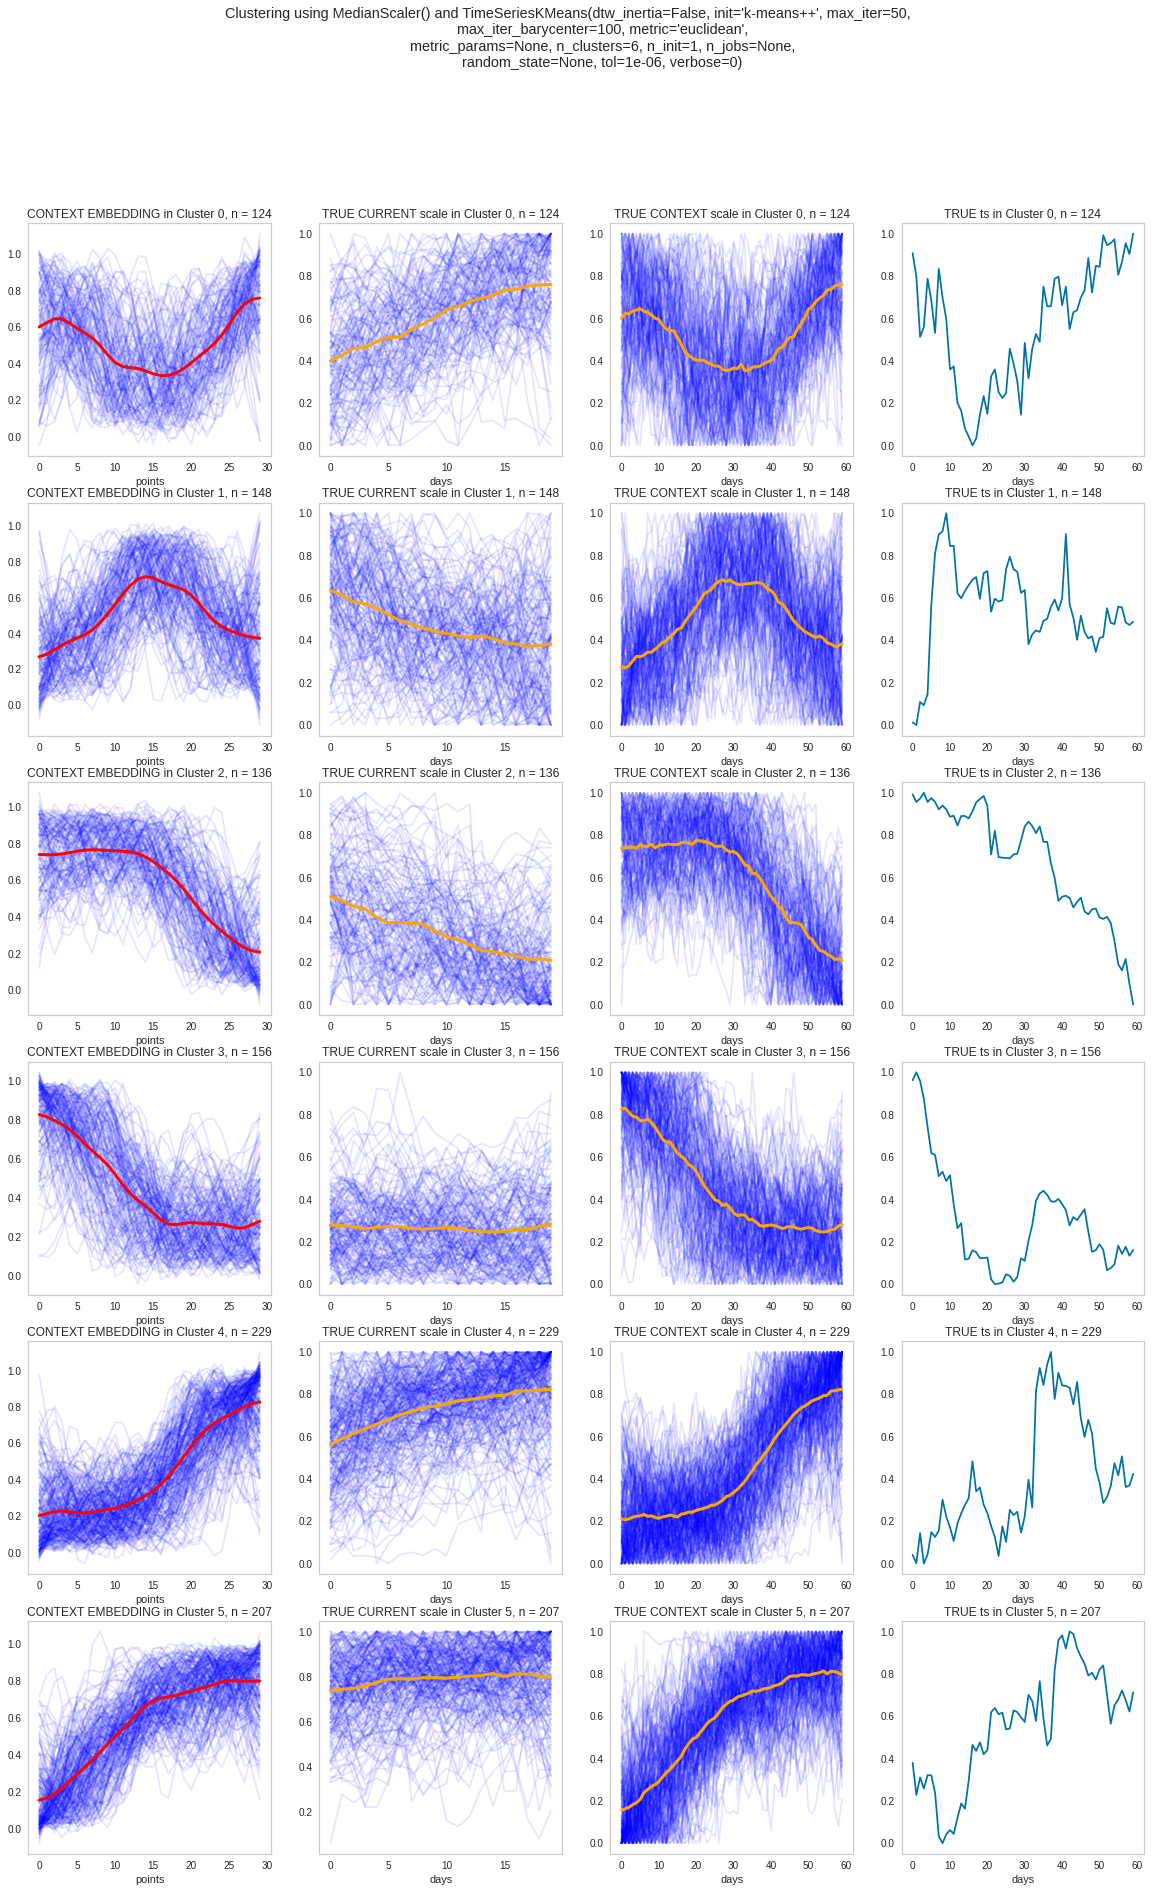

In [ ]:
context = context_matrix.copy()
context_matrix_scale = np.transpose(MinMaxScaler().fit_transform(np.transpose(context)))
current_matrix_scale = context_matrix_scale.copy()[:,context_scale - current_scale:]
context_matrix_pip = reduce_dimension(context_matrix_scale.copy(), 30)
context_matrix_smooth = DCT_lowpass_filter().fit_transform(context_matrix_pip.copy())
cluster_context_embed(context_matrix_smooth, current_matrix_scale, context_matrix_scale, TimeSeriesKMeans(n_clusters=6))

plt.suptitle('Clustering using '+ str(scaler) + " and " + str(TimeSeriesKMeans(n_clusters=6)))